# Likelihood Emulation 

### Run and Folder Settings

In [309]:
### RUN SETTINGS ###
numbered_training_schemes = ["1_Offline", "2_Online", "3_Dynamic"]
training_schemes = ["offline", "online", "dynamic"]
training_schemes_nums = [1, 2, 3]

# Some imports
import random, string, copy, sys, torch

# Seeding
seed = 223174  # torch.randint(1000000, (1,))
torch.manual_seed(seed)

# Generate a random string
# with x characters.
num_chars = 10
RUN_ID = ''.join([random.choice(string.ascii_letters
            + string.digits) for n in range(num_chars)])

COMP_RUN_ID = copy.deepcopy(RUN_ID)

run_all = False
save_nets = True
save_metrics = True
save_figs = True


### FOLDER SETTINGS ###
PROJECT_DIR = r'C:\Users\Filipe\Documents\GitHub'

ddm_task_folder = PROJECT_DIR + r'\sbibm-ddm-task'
ddm_task_sbibm_folder = PROJECT_DIR + r'\sbibm-ddm-task\sbibm'
mnle_for_ddms_folder = PROJECT_DIR + r'\mnle-for-ddms\notebooks'

project_folders = [ddm_task_folder, ddm_task_sbibm_folder, mnle_for_ddms_folder]
for project_folder in project_folders:
    sys.path.append(project_folder)

SAVE_DIR = r"E:\Filipe_File_Dump"

run_folder = SAVE_DIR + "\\runs\\"
dictionary_folder = SAVE_DIR + "\\runs\\run_dictionary_dump_comparison\\"
plot_folder = SAVE_DIR + "\\runs\\run_plot_dump_comparison\\"

### Import Modules

In [310]:
import torch
from torch import zeros, ones, eye, nn
from torch.distributions import MultivariateNormal
from torch.distributions import Beta, Binomial, Gamma, Uniform, Normal
from torch.distributions.transforms import AffineTransform, identity_transform
from pyro.distributions import InverseGamma

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import clear_output

from scipy.signal import find_peaks,find_peaks_cwt
from scipy.ndimage.filters import gaussian_filter1d
from scipy import interpolate
from scipy.stats import binom_test

import pickle, dill, copy
import time
from datetime import datetime
from pathlib import Path
import random, string
import sys

C:\Users\Filipe\AppData\Local\Temp\ipykernel_20040\3689811403.py:16: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [311]:
from julia import Julia
from sbibm.tasks.ddm.task import *
from sbibm.tasks.ddm.utils import *

# from analytical_likelihood_2D_DDM import *
# from mnle_likelihood_2D_DDM import *

In [312]:
from sbi.inference import MNLE
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st

from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    true_posterior_linear_gaussian_mvn_prior,
)

from base_utils import (
    #load_lan,
    #lan_likelihood_on_batch,
    apply_lower_bound_given_mask,
    huber_loss,
    mean_squared_error,
    decode_1d_to_2d_x,
    plot_bar,
)

### Plotting Settings

In [313]:
# Plotting settings
#from matplotlib import mplstyle
#plt.style.use("plotting_settings.mplstyle")
# Colorblind color palette
colors = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

linestyles = [":", "--", "-", "-."]

unbounded_training_param = True
ana_color = "k"
ana_fill_color = "lightblue"
alpha = 0.2
alpha_mnle = 0.5

# Set log-likelihood lower bound for all methods, use 1e-7 as the highest bound used during training (e.g., for 10^11 budget LANs).
l_lower_bound = 1e-7
LL_LOWER_BOUND = np.log(l_lower_bound)

### Functions

In [314]:
def simulator_split(theta):
    xs = simulator(theta)    # (rts*choices) column vector
    x = map_x_to_two_D(xs)   # (rts, choices), where incorrect choices are coded as -1
    x[:, 1] = (x[:, 1]+1)/2  # incorrect choices coded as 0s
    return x


def analytical_likelihood(parameters, data):

    num_samps, _ = parameters.shape
    
    theo_probs = np.empty(shape=(num_samps))
    theo_c_probs = np.empty(shape=(num_samps))

    for n in range(num_samps):
        drift, boundary = parameters[n,0].detach().numpy(), parameters[n,1].detach().numpy()
        rtime, choice = data[n,0].detach().numpy(), data[n,1].detach().numpy()
        rtime, choice = np.expand_dims(rtime,axis=0), np.expand_dims(choice,axis=0)
        theo_probs[n] = d_RT(mu=drift, a=0.5*boundary, rt=rtime, c=choice) 
        if choice == 1:
            theo_c_probs[n] = 0.5 * (1 + np.tanh(drift * 0.5*boundary))
        else:
            theo_c_probs[n] = 0.5 * (1 + np.tanh(-drift * 0.5*boundary))

    return np.log(theo_c_probs), np.log(theo_probs)


# Define helper functions for computing likelihood accuracies systematically.
def score_mnle(mnle, num_observations, num_thetas_per_observation):
    """Returns likelihood approximation metrics given a path to a pre-trained MNLE."""

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_theta = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        rts = abs(xoi)

        # Evaluate
        lps_mnle_i = mnle.log_prob(
            xos[idx].repeat(num_thetas_per_observation, 1), test_theta
        ).detach()

        # apply lower bound and ndt constraint.
        rt_smaller_ndt = rts.repeat(1, test_theta.shape[0]) < test_theta[:, -1]
        below_bound = lps_mnle_i < LL_LOWER_BOUND

        mask = torch.logical_or(rt_smaller_ndt, below_bound).squeeze()

        lps_true_i = task.get_log_likelihood(
            test_theta, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND)
        )

        # Score
        errors.append(
            [
                huber_loss(lps_mnle_i, lps_true_i),
                huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
                mean_squared_error(lps_mnle_i, lps_true_i),
                mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ]
        )

    return np.array(errors)


# Define helper functions for computing likelihood curvatures systematically.
def curvature_score_mnle(mnle, num_observations, num_thetas_per_observation):
    """Returns likelihood approximation curvature metrics given a path to a pre-trained MNLE."""

    l_lower_bound = 1e-7

    # RT range
    test_tmax = 2
    # Number of test points
    ntest = num_observations#1000
    rs = torch.cat(
        (
            torch.linspace(test_tmax, l_lower_bound, ntest // 2),
            torch.linspace(l_lower_bound, test_tmax, ntest // 2),
        )
    ).reshape(-1, 1)
    cs = torch.cat((torch.zeros(ntest // 2), torch.ones(ntest // 2))).reshape(-1, 1)

    test_x = torch.hstack((rs, cs))
    test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

    curvatures = []
    for idx in range(num_thetas_per_observation):
        # Sample test thetas from prior.
        test_theta = thos[idx][0]

        # Evaluate
        lps_mnle_i = mnle.log_prob(
            test_x, test_theta.repeat(test_x.shape[0], 1)
        ).detach()

        lps_true_i = torch.tensor(
            [
                task.get_log_likelihood(test_theta.repeat(1, 1), d.reshape(-1, 1), l_lower_bound=l_lower_bound)
                for d in test_rts
            ]
        )

        secdev_mnle = second_derivative_1d_score(lps_mnle_i.exp())
        secdev_true = second_derivative_1d_score(lps_true_i.exp())
        sd_score = np.mean(np.abs(secdev_mnle))/np.mean(np.abs(secdev_true))
        #sd_score = secdev_mnle

        # Score
        curvatures.append(
            [
                sd_score
            ]
        )

    return np.array(curvatures)


# Define helper functions for computing likelihood curvatures systematically.
def peak_score_mnle(mnle, num_observations, num_thetas_per_observation):
    """Returns likelihood approximation peak metrics given a path to a pre-trained MNLE."""

    l_lower_bound = 1e-7

    # RT range
    test_tmax = 2
    # Number of test points
    ntest = num_observations#1000
    rs = torch.cat(
        (
            torch.linspace(test_tmax, l_lower_bound, ntest // 2),
            torch.linspace(l_lower_bound, test_tmax, ntest // 2),
        )
    ).reshape(-1, 1)
    cs = torch.cat((torch.zeros(ntest // 2), torch.ones(ntest // 2))).reshape(-1, 1)

    test_x = torch.hstack((rs, cs))
    test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

    peak_counts = []
    for idx in range(num_thetas_per_observation):
        # Sample test thetas from prior.
        test_theta = thos[idx][0]

        # Evaluate
        lps_mnle_i = mnle.log_prob(
            test_x, test_theta.repeat(test_x.shape[0], 1)
        ).detach()

        lps_true_i = torch.tensor(
            [
                task.get_log_likelihood(test_theta.repeat(1, 1), d.reshape(-1, 1), l_lower_bound=l_lower_bound)
                for d in test_rts
            ]
        )

        peaks_mnle, heights_mnle = find_peaks(lps_mnle_i.exp(), height=0.001)

        peaks_true, heights_true = find_peaks(lps_true_i.exp(), height=0.001)

        num_peaks_mnle = len(peaks_mnle)

        num_peaks_true = len(peaks_true)

        # Score
        peak_counts.append(
            [
                num_peaks_mnle#/num_peaks_true
            ]
        )

    return np.array(peak_counts)


def second_derivative_2d_score(y):
    _, num_cols = y.shape
    y[np.isnan(y)] = 0

    dd_total = 0

    for col in range(num_cols):
        dy = np.gradient(y[:,col])
        ddy = np.gradient(dy)
        dd_total += sum(ddy**2)

    return np.mean(dd_total)


def second_derivative_1d_score(y):
    y[np.isnan(y)] = 0

    dy = np.gradient(y)
    ddy = np.gradient(dy)

    return ddy

### Systematic Likelihood comparison

Next we do a systematic comparison based on the Huber loss (the LAN training loss) and the mean squared error (MSE) between analytical and synthetic log likelihoods of LAN and NLE.

During inference the observation is usually fixed and one evaluates the likelihood for a set of parameters sampled from the prior or a MCMC chain. To mimick this inference setup when comparison the estimated likelihoods, we sample an observation from the simulator given parameters from the prior, and obtain the likelihood of this observation given a large batch of parameters sampled from the prior, e.g., `1000`. The Huber loss and MSE are then calculated across this batch, resulting in a single number. We repeat this procedure for many observation, e.g., `100`, and then show boxplots over the resulting 100 numbers. 

In [315]:
# Secondary hyperparameters
training_batch_size = 50
starting_training_batch_size = 50#50
training_batch_size_step = 50#50
learning_rate = 5e-3
#num_simulations = 10**4
max_num_epochs = 200
stop_after_epochs = max_num_epochs
max_num_epochs_list = [10, 20, 100]
max_num_effective_sims_list = [10**5, 10**6, 10**7, 10**8]#[10**3, 10**4, 10**5, 10**6, 10**7]#, 10**5, 10**6]
sim_budgets = max_num_effective_sims_list
initial_num_effective_sims_list = [10**5, 10**6]
num_realisations = 3
use_amsgrad= False
unbounded_training = unbounded_training_param
min_training_std = 0.0001
min_training_ma_std = 0.0001

In [316]:
run_folder

'E:\\Filipe_File_Dump\\runs\\'

In [317]:
RUN_ID

'h8FWdtMT9q'

In [318]:
run_file_names = os.listdir(Path(dictionary_folder))
run_paths = [dictionary_folder + run_file_name for run_file_name in run_file_names]

In [319]:
run_paths

['E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_SUDBFmCi3Y_1_Offline_B_Jul-09-2023_0441',
 'E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_Tl1LYZWIeS_2_Online_B_Jul-09-2023_0443',
 'E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_xaN4NjL6Mv_3_Dynamic_B_Jul-09-2023_0448']

In [320]:
training_scheme_order = []
for run_path in run_paths:
    for training_scheme_num in np.arange(1, len(numbered_training_schemes)+1):
        if numbered_training_schemes[training_scheme_num-1] in run_path:
            training_scheme_order.append(training_scheme_num-1)

In [321]:
training_scheme_order

[0, 1, 2]

In [325]:
matching_run_paths = [run_paths[i] for i in training_scheme_order]

In [326]:
print(run_paths)
print(matching_run_paths)

['E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_SUDBFmCi3Y_1_Offline_B_Jul-09-2023_0441', 'E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_Tl1LYZWIeS_2_Online_B_Jul-09-2023_0443', 'E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_xaN4NjL6Mv_3_Dynamic_B_Jul-09-2023_0448']
['E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_SUDBFmCi3Y_1_Offline_B_Jul-09-2023_0441', 'E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_Tl1LYZWIeS_2_Online_B_Jul-09-2023_0443', 'E:\\Filipe_File_Dump\\runs\\run_dictionary_dump_comparison\\run_xaN4NjL6Mv_3_Dynamic_B_Jul-09-2023_0448']


In [327]:
matching_run_dictionaries = []
matching_run_ids = []

for run_path in matching_run_paths:

    # load run
    with open(run_path, "rb") as fh:
        matching_run_dictionary = dill.load(fh)

    matching_run_dictionaries.append(matching_run_dictionary)    
    matching_run_ids.append(list(matching_run_dictionary.keys())[0])  

In [333]:
matching_run_dictionaries
matching_run_ids

['SUDBFmCi3Y', 'Tl1LYZWIeS', 'xaN4NjL6Mv']

In [329]:
ines_len = len(initial_num_effective_sims_list)

In [330]:
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
f.set_powerlimits((-8,8))

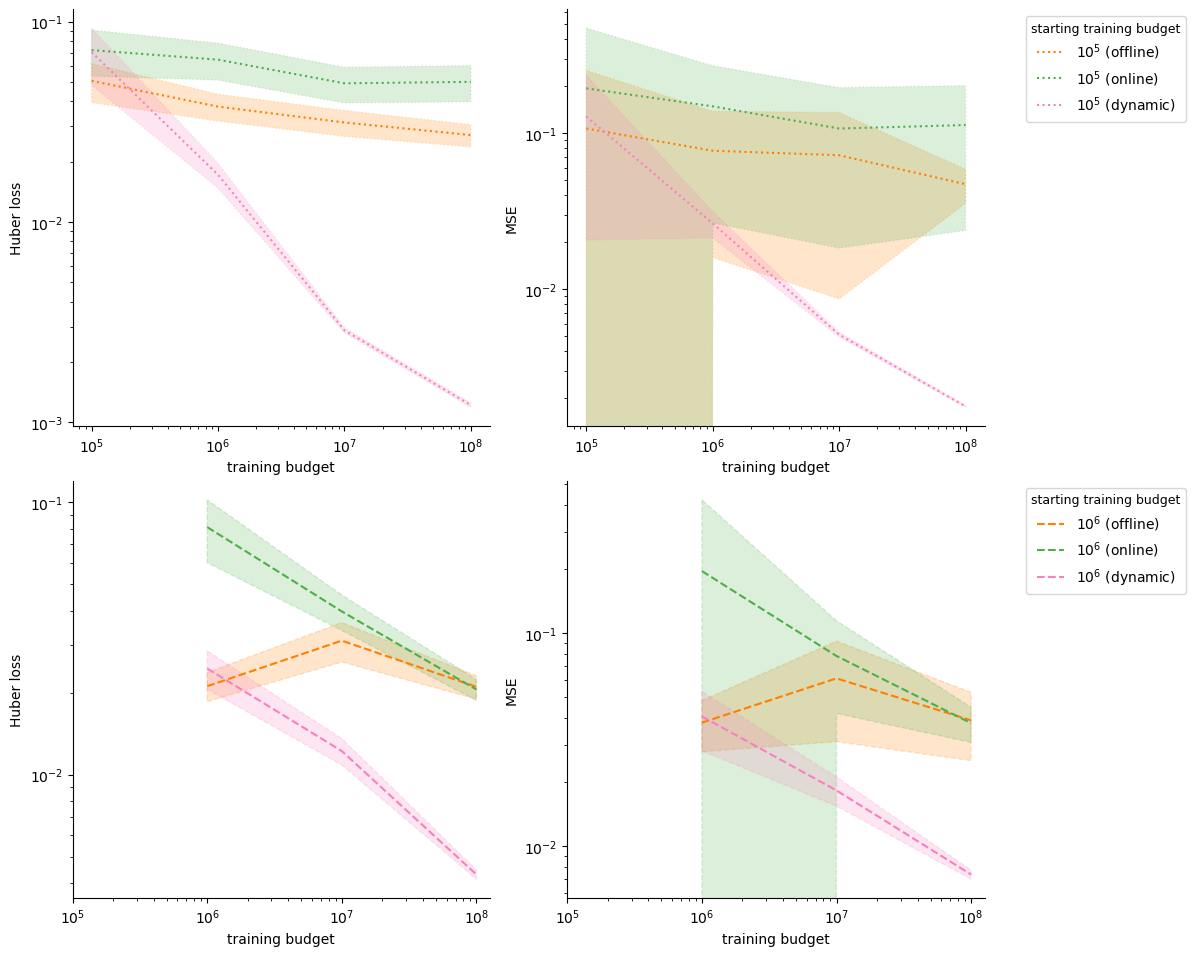

In [334]:
sys_errors_fig, sys_errors_ax = plt.subplots(ines_len,2)
sys_errors_fig.set_figwidth(12)
sys_errors_fig.set_figheight(12)
y_log_scale = True
tick_spacing = 0.1

for training_scheme_num in np.arange(1, len(training_schemes)+1):

    training_scheme = numbered_training_schemes[training_scheme_num-1]
    label_training_scheme = training_schemes[training_scheme_num-1]
    RUN_ID = matching_run_ids[training_scheme_num-1]

    mnle_color = colors[training_scheme_num]
    mnle_fill_color = mnle_color

    matching_run_dictionary = matching_run_dictionaries[training_scheme_num-1]

    ines_counter = 0

    for initial_num_effective_sims_item in initial_num_effective_sims_list:

        try:
            matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item]
        except (KeyError, TypeError, NameError):
            continue

        saturation_training_budget = initial_num_effective_sims_item*((initial_num_effective_sims_item-starting_training_batch_size)/training_batch_size_step)

        linestyle = linestyles[ines_counter]

        y_huber = []
        yerr_huber = []

        y_mse = []
        yerr_mse = []

        for max_num_effective_sims_item in max_num_effective_sims_list:

            try:
                matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][1][max_num_effective_sims_item]
            except (KeyError, TypeError, NameError):
                continue

            if max_num_effective_sims_item < initial_num_effective_sims_item:
                continue

            errors = []
                
            for realisation in range(1,num_realisations+1):

                try:
                    matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item]
                except (KeyError, TypeError, NameError):
                    continue

                content = "metric"

                metric = "error"

                realisation_wise_errors = matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item][content][metric]

                errors.append(realisation_wise_errors)

            realisation_averaged_errors = np.mean(np.asarray(errors),axis=0)

            y_huber.append(realisation_averaged_errors[:,1].mean())
            yerr_huber.append(realisation_averaged_errors[:,1].var())

            y_mse.append(realisation_averaged_errors[:,3].mean())
            yerr_mse.append(realisation_averaged_errors[:,3].var())


        y_huber = np.asarray(y_huber)
        yerr_huber = np.asarray(yerr_huber)

        y_mse = np.asarray(y_mse)
        yerr_mse = np.asarray(yerr_mse)

        row = ines_counter

        col = 0

        y = y_huber
        yerr = yerr_huber

        sys_errors_ax[row,col].plot(sim_budgets[-len(y):], y, c=mnle_color, linestyle=linestyles[ines_counter], label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_errors_ax[row,col].fill_between(sim_budgets[-len(y):], y-yerr, y+yerr, color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_errors_ax[row,col].set_xlabel("training budget")
        sys_errors_ax[row,col].set_ylabel("Huber loss")
        sys_errors_ax[row,col].set_box_aspect(1)
        sys_errors_ax[row,col].spines[['right', 'top']].set_visible(False)

        sys_errors_ax[row,col].set_xscale('log')
        sys_errors_ax[row,col].set_yscale('log')
        sys_errors_ax[row,col].set_xticks(sim_budgets)
        #sys_errors_ax[row,col].set_ylim(bottom=-10, top=10)
        #sys_errors_ax[row,col].legend()

        if unbounded_training_param == False:
            sys_errors_ax[row,col].axvline(saturation_training_budget, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        col = 1

        y = y_mse
        yerr = yerr_mse

        sys_errors_ax[row,col].plot(sim_budgets[-len(y):], y, c=mnle_color, linestyle=linestyles[ines_counter], label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_errors_ax[row,col].fill_between(sim_budgets[-len(y):], y-yerr, y+yerr, color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_errors_ax[row,col].set_xlabel("training budget")
        sys_errors_ax[row,col].set_ylabel("MSE")
        sys_errors_ax[row,col].set_box_aspect(1)
        sys_errors_ax[row,col].spines[['right', 'top']].set_visible(False)

        sys_errors_ax[row,col].set_xscale('log')
        sys_errors_ax[row,col].set_yscale('log')
        sys_errors_ax[row,col].set_xticks(sim_budgets)
        #sys_errors_ax[row,col].set_ylim(bottom=-10, top=10)
        #sys_errors_ax[row,col].yaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
        sys_errors_ax[row,col].legend(title="starting training budget", bbox_to_anchor=(1.5, 1), title_fontsize=9)

        if unbounded_training_param == False:
            sys_errors_ax[row,col].axvline(saturation_training_budget, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        plt.tight_layout()

        ines_counter += 1

# save_figs = True

if save_figs:

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)

    filename = "metrics_errors_"+COMP_RUN_ID+"_"+timestamp
    filepath = plot_folder + filename

    plt.savefig(filepath+'.pdf')

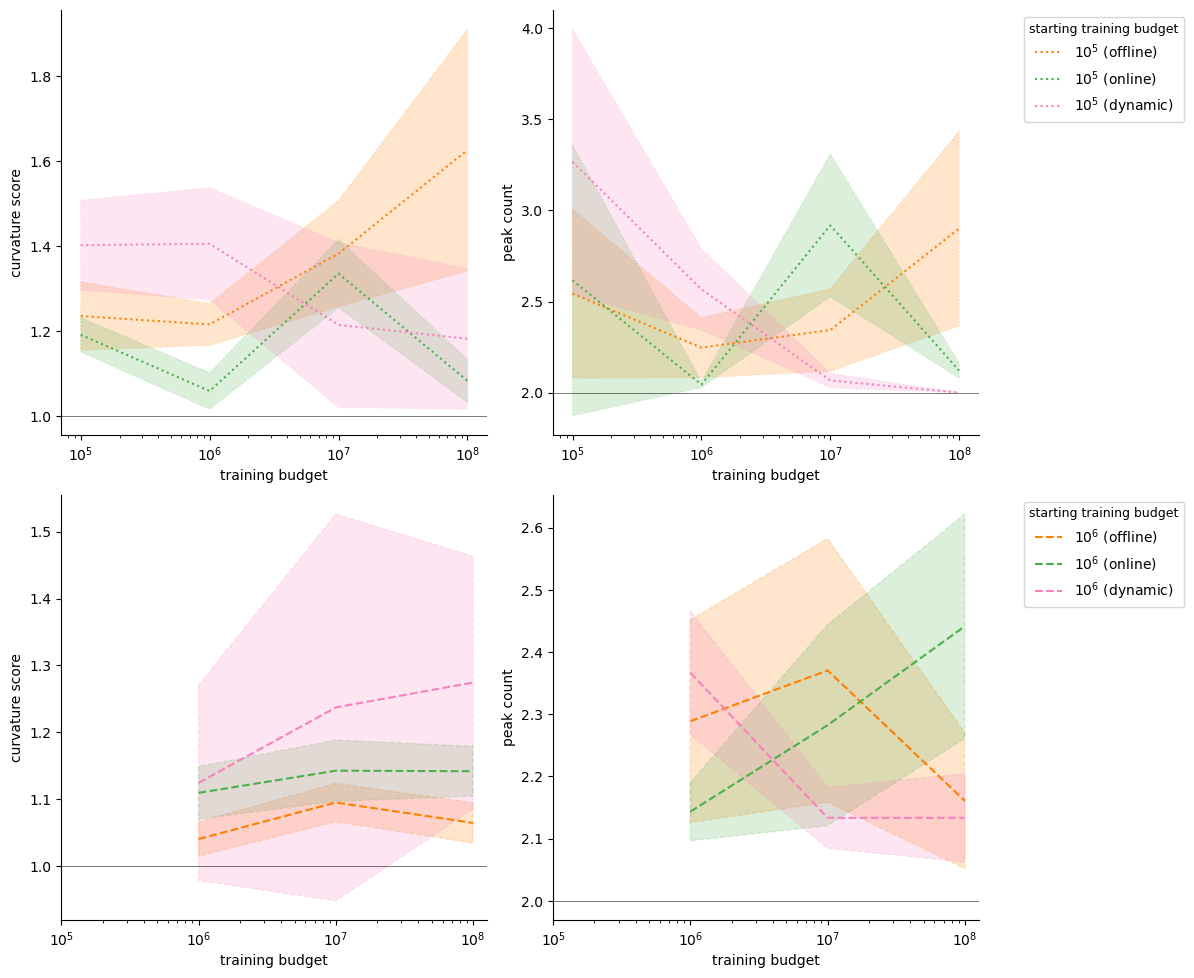

In [335]:
sys_curvatures_fig, sys_curvatures_ax = plt.subplots(ines_len,2)
sys_curvatures_fig.set_figwidth(12)
sys_curvatures_fig.set_figheight(12)
y_log_scale = True
tick_spacing = 0.5

thresh_min, thresh_max = 0, 10
data_min, data_max = thresh_min*np.ones(shape=(ines_len,2)), thresh_max*np.ones(shape=(ines_len,2))

for training_scheme_num in np.arange(1, len(training_schemes)+1):

    training_scheme = numbered_training_schemes[training_scheme_num-1]
    label_training_scheme = training_schemes[training_scheme_num-1]
    RUN_ID = matching_run_ids[training_scheme_num-1]

    mnle_color = colors[training_scheme_num]
    mnle_fill_color = mnle_color

    matching_run_dictionary = matching_run_dictionaries[training_scheme_num-1]

    ines_counter = 0

    for initial_num_effective_sims_item in initial_num_effective_sims_list:

        try:
            matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item]
        except (KeyError, TypeError, NameError):
            continue

        saturation_training_budget = initial_num_effective_sims_item*((initial_num_effective_sims_item-starting_training_batch_size)/training_batch_size_step)

        linestyle = linestyles[ines_counter]

        y_curvs = []
        yerr_curvs = []

        y_pks = []
        yerr_pks = []
        x = []

        for max_num_effective_sims_item in max_num_effective_sims_list:

            try:
                matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][1][max_num_effective_sims_item]
            except (KeyError, TypeError, NameError):
                continue

            if max_num_effective_sims_item < initial_num_effective_sims_item:
                continue

            curvatures = []
            peaks= []
                
            for realisation in range(1,num_realisations+1):

                content = "metric"

                metric = "curvature"

                try:
                    matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item][content][metric]
                except (KeyError, TypeError, NameError):
                    continue
                realisation_wise_curvatures = matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item][content][metric]
                curvatures.append(realisation_wise_curvatures)

                metric = "peak"

                try:
                    matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item][content][metric]
                except (KeyError, TypeError, NameError):
                    continue
                realisation_wise_peaks = matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item][content][metric]
                peaks.append(realisation_wise_peaks)

            realisation_averaged_curvs = np.mean(np.asarray(curvatures), axis=0)
            realisation_averaged_pks = np.mean(np.asarray(peaks), axis=0)

            y_curvs.append(realisation_averaged_curvs.mean())
            yerr_curvs.append(realisation_averaged_curvs.var())

            y_pks.append(realisation_averaged_pks.mean())
            yerr_pks.append(realisation_averaged_pks.var())

            x.append(max_num_effective_sims_item)


        y_curvs = np.asarray(y_curvs)
        yerr_curvs = np.asarray(yerr_curvs)

        y_pks = np.asarray(y_pks)
        yerr_pks = np.asarray(yerr_pks)

        row = ines_counter

        col = 0

        y = y_curvs
        yerr = yerr_curvs
        if data_min[row,col] > min(y-yerr):
            data_min[row,col] = min(y-yerr)
        if data_max[row,col] < max(y+yerr):
            data_max[row,col] = max(y+yerr)

        sys_curvatures_ax[row,col].plot(x, y, c=mnle_color, linestyle=linestyle, label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_curvatures_ax[row,col].fill_between(x, y-yerr, y+yerr, color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_curvatures_ax[row,col].set_xlabel("training budget")
        sys_curvatures_ax[row,col].set_ylabel("curvature score")
        sys_curvatures_ax[row,col].set_box_aspect(1)
        sys_curvatures_ax[row,col].spines[['right', 'top']].set_visible(False)

        sys_curvatures_ax[row,col].set_xscale('log')
        #sys_curvatures_ax[row,col].set_yscale('log')
        sys_curvatures_ax[row,col].set_xticks(sim_budgets)
        #sys_curvatures_ax[row,col].yaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
        #sys_curvatures_ax[row,col].set_ylim(bottom=-0.1)
        sys_curvatures_ax[row,col].axhline(1, color="k", alpha=0.3, linewidth=0.5)

        if unbounded_training_param == False:
            sys_curvatures_ax[row,col].axvline(saturation_training_budget, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        col = 1

        y = y_pks
        yerr = yerr_pks
        if data_min[row,col] > min(y-yerr):
            data_min[row,col] = min(y-yerr)
        if data_max[row,col] < max(y+yerr):
            data_max[row,col] = max(y+yerr)

        sys_curvatures_ax[row,col].plot(x, y, c=mnle_color, linestyle=linestyle, label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_curvatures_ax[row,col].fill_between(x, y-yerr, y+yerr, color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_curvatures_ax[row,col].set_xlabel("training budget")
        sys_curvatures_ax[row,col].set_ylabel("peak count")
        sys_curvatures_ax[row,col].set_box_aspect(1)
        sys_curvatures_ax[row,col].spines[['right', 'top']].set_visible(False)
        sys_curvatures_ax[row,col].set_visible(True)
        sys_curvatures_ax[row,col].set_xscale('log')
        #sys_curvatures_ax[row,col].set_yscale('log')
        sys_curvatures_ax[row,col].set_xticks(sim_budgets)
        #sys_curvatures_ax[row,col].yaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
        sys_curvatures_ax[row,col].axhline(2, color="k", alpha=0.3, linewidth=0.5)
        sys_curvatures_ax[row,col].legend(title="starting training budget", bbox_to_anchor=(1.5, 1), title_fontsize=9)

        if unbounded_training_param == False:
            sys_curvatures_ax[row,col].axvline(saturation_training_budget, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        plt.tight_layout()

        ines_counter += 1

for row in range(ines_len):
    for col in range(2):
        if (data_max[row,col] > thresh_max).sum() > 0: 
            sys_curvatures_ax[row,col].set_ylim(ymax=thresh_max)
        if (data_min[row,col] < thresh_min).sum() > 0:
            sys_curvatures_ax[row,col].set_ylim(ymin=thresh_min)

# save_figs = True

if save_figs:

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)

    filename = "metrics_curvatures_"+COMP_RUN_ID+"_"+timestamp
    filepath = plot_folder + filename

    plt.savefig(filepath+'.pdf')

In [358]:
# create two lists  with college id and name
lower_bounds = [0, 0, 0]
upper_bounds = [10**8, 10**8, 10**3]
 
# zip the two lists using zip() function
data = list(zip(lower_bounds, upper_bounds))
 
# display data
data

[(0, 100000000), (0, 100000000), (0, 1000)]

In [361]:
# create two lists  with college id and name
lower_bounds = [[0, 0, 0], [0, 0, 0]]
upper_bounds = [[10**7, 10**7, 0.5*10**3], [10**8, 10**8, 10**3]]
 
# zip the two lists using zip() function
data = list(zip(lower_bounds, upper_bounds))
 
# display data
data

[([0, 0, 0], [10000000, 10000000, 500.0]),
 ([0, 0, 0], [100000000, 100000000, 1000])]

C:\Users\Filipe\AppData\Local\Temp\ipykernel_20040\4148893757.py:151: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  sys_training_times_ax[row,col].set_ylim(axes_lims[col])


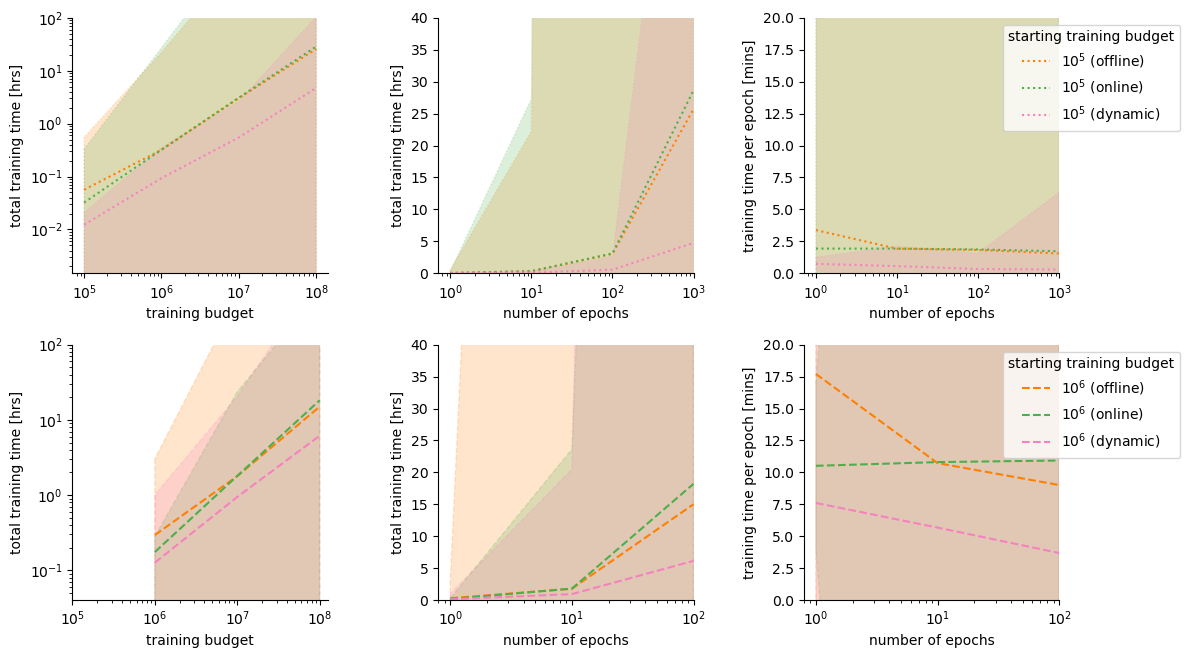

In [371]:
sys_training_times_fig, sys_training_times_ax = plt.subplots(ines_len,3)
sys_training_times_fig.set_figwidth(12)
sys_training_times_fig.set_figheight(12)
y_log_scale = True
tick_spacing = 0.5
time_unit_hr = 3600 #1 hours in secs
time_unit_min = 60 #1 min in secs

lower_bounds = [0, 0, 0]
upper_bounds = [100, 40, 20]
# zip the two lists using zip() function
axes_lims = list(zip(lower_bounds, upper_bounds))

for training_scheme_num in np.arange(1, len(training_schemes)+1):

    training_scheme = numbered_training_schemes[training_scheme_num-1]
    label_training_scheme = training_schemes[training_scheme_num-1]
    RUN_ID = matching_run_ids[training_scheme_num-1]

    mnle_color = colors[training_scheme_num]
    mnle_fill_color = mnle_color

    matching_run_dictionary = matching_run_dictionaries[training_scheme_num-1]

    ines_counter = 0

    for initial_num_effective_sims_item in initial_num_effective_sims_list:

        try:
            matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item]
        except (KeyError, TypeError, NameError):
            continue

        saturation_training_budget = initial_num_effective_sims_item*((initial_num_effective_sims_item-starting_training_batch_size)/training_batch_size_step)

        linestyle = linestyles[ines_counter]

        y_times = []
        yerr_times = []
        x = []

        for max_num_effective_sims_item in max_num_effective_sims_list:

            try:
                matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][1][max_num_effective_sims_item]
            except (KeyError, TypeError, NameError):
                continue

            if max_num_effective_sims_item < initial_num_effective_sims_item:
                continue

            training_times = []
                
            for realisation in range(1,num_realisations+1):

                content = "metric"

                metric = "training_time"

                try:
                    realisation_wise_training_times = matching_run_dictionary[RUN_ID][training_scheme][initial_num_effective_sims_item][realisation][max_num_effective_sims_item][content][metric]
                except (KeyError, TypeError, NameError):
                    continue

                training_times.append(realisation_wise_training_times)

            y_times.append(np.asarray(training_times).mean())
            yerr_times.append(np.asarray(training_times).var())
            x.append(max_num_effective_sims_item)

        y_times = np.asarray(y_times)
        yerr_times = np.asarray(yerr_times)

        row = ines_counter

        col = 0

        y = y_times/time_unit_hr
        yerr = yerr_times/time_unit_hr

        sys_training_times_ax[row,col].plot(x, y, c=mnle_color, linestyle=linestyle, label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_training_times_ax[row,col].fill_between(x, (y-yerr), (y+yerr), color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_training_times_ax[row,col].set_xlabel("training budget")
        sys_training_times_ax[row,col].set_ylabel("total training time [hrs]")
        sys_training_times_ax[row,col].set_box_aspect(1)
        sys_training_times_ax[row,col].spines[['right', 'top']].set_visible(False)

        sys_training_times_ax[row,col].set_xscale('log')
        sys_training_times_ax[row,col].set_yscale('log')
        sys_training_times_ax[row,col].set_xticks(sim_budgets)
        #sys_training_times_ax[row,col].yaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
        #sys_training_times_ax[row,col].set_ylim(bottom=-0.1)

        if unbounded_training_param == False:
            sys_training_times_ax[row,col].axvline(saturation_training_budget, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        col = 1

        x_epo = (np.asarray(x)/x[0])
        y = y_times/time_unit_hr
        yerr = yerr_times/time_unit_hr
        
        sys_training_times_ax[row,col].plot(x_epo, y, c=mnle_color, linestyle=linestyle, label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_training_times_ax[row,col].fill_between(x_epo, (y-yerr), (y+yerr), color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_training_times_ax[row,col].set_xlabel("number of epochs")
        sys_training_times_ax[row,col].set_ylabel("total training time [hrs]")
        sys_training_times_ax[row,col].set_box_aspect(1)
        sys_training_times_ax[row,col].spines[['right', 'top']].set_visible(False)

        sys_training_times_ax[row,col].set_xscale('log')
        #sys_training_times_ax[row,col].set_yscale('log')
        #sys_training_times_ax[row,col].set_xticks(x)
        #sys_training_times_ax[row,col].yaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
        #sys_training_times_ax[row,col].set_ylim(bottom=-0.1)
        sys_training_times_ax[row,col].set_xlim(right=max(x_epo))
        #sys_training_times_ax[1].set_visible(False)

        if unbounded_training_param == False:
            sys_training_times_ax[row,col].axvline(saturation_training_budget/initial_num_effective_sims_item, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        col = 2

        y = y_times/x_epo/time_unit_min
        yerr = yerr_times/x_epo/time_unit_min

        sys_training_times_ax[row,col].plot(x_epo, y, c=mnle_color, linestyle=linestyle, label="${}$ ({})".format(f.format_data(initial_num_effective_sims_item), label_training_scheme))
        sys_training_times_ax[row,col].fill_between(x_epo, (y-yerr), (y+yerr), color=mnle_color, alpha=alpha, linestyle=linestyle)
        sys_training_times_ax[row,col].set_xlabel("number of epochs")
        sys_training_times_ax[row,col].set_ylabel("training time per epoch [mins]")
        sys_training_times_ax[row,col].set_box_aspect(1)
        sys_training_times_ax[row,col].spines[['right', 'top']].set_visible(False)

        sys_training_times_ax[row,col].set_xscale('log')
        #sys_training_times_ax[row,col].set_yscale('log')
        #sys_training_times_ax[row,col].set_xticks(x)
        #sys_training_times_ax[row,col].yaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
        #sys_training_times_ax[row,col].set_ylim(bottom=-0.1)
        sys_training_times_ax[row,col].set_xlim(right=max(x_epo))
        #sys_training_times_ax[1].set_visible(False)
        sys_training_times_ax[row,col].legend(title="starting training budget", bbox_to_anchor=(1.5, 1))#, title_fontsize=9) #loc="upper right"

        if unbounded_training_param == False:
            sys_training_times_ax[row,col].axvline(saturation_training_budget/initial_num_effective_sims_item, color="k", alpha=0.3, linewidth=1, linestyle=linestyle)

        plt.tight_layout()

        ines_counter += 1

for row in range(ines_len):
    for col in range(3):
        sys_training_times_ax[row,col].set_ylim(axes_lims[col])

save_figs = False

if save_figs:

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)

    filename = "metrics_training_times_"+COMP_RUN_ID+"_"+timestamp
    filepath = plot_folder + filename

    plt.savefig(filepath+'.pdf')

In [ ]:
if not run_all:
    sys.exit(0)

SystemExit: 0

c:\Users\Filipe\anaconda3\envs\mnle_for_ddms_env\Lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
